## Model Training

### Importing Libraries and ML Algorithms

In [2]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Models for Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model Evaluation Metrics for Classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score


### Import CSV data as Pandas dataframe

In [3]:
data = pd.read_csv('data/data_recombined.csv')
data.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,20,0,0,0,1,2,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,27,1,0,0,0,3,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,15,1,0,0,0,3,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,14,1,0,1,1,2,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,14,1,0,0,0,1,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0


### Preparing X and y variables

In [4]:
# data splits into X and y
X = data.drop(columns='treatment')
y = data['treatment']

In [5]:
X.head()

,Age,Gender,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,20,0,0,0,2,4,0,1,2,1,...,2,2,1,1,1,2,1,0,2,0
1,27,1,0,0,3,5,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,15,1,0,0,3,4,0,1,1,0,...,0,1,1,1,2,2,2,2,1,0
3,14,1,0,1,2,2,0,1,1,2,...,1,1,2,2,1,0,0,0,1,1
4,14,1,0,0,1,1,1,1,2,0,...,0,0,1,1,1,2,2,2,0,0


In [6]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: treatment, dtype: int64

### Splitting dataset into train and test

In [7]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1005, 22), (252, 22))

#### Create an Evaluate funtion to give all metrics after model Training

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(true, predicted, predicted_proba=None):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average="weighted")
    recall = recall_score(true, predicted, average="weighted")
    f1 = f1_score(true, predicted, average="weighted")

    # Compute AUC-ROC only if probabilities are available
    auc_roc = None
    if predicted_proba is not None:
        try:
            auc_roc = roc_auc_score(true, predicted_proba, multi_class="ovr", average="weighted")
        except ValueError:
            auc_roc = None  # Handle cases where AUC-ROC cannot be calculated

    return accuracy, precision, recall, f1, auc_roc


In [9]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100),
    "XGB Classifier": XGBClassifier(objective="multi:softmax", num_class=len(y.unique())), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Support Vector Classifier": SVC(probability=True)  # Ensure probability=True for AUC-ROC
}

model_list = []
accuracy_list =[]

# Loop through models
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Check if model supports predict_proba()
    y_train_proba = model.predict_proba(X_train) if hasattr(model, "predict_proba") else None
    y_test_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Evaluate Train and Test dataset
    model_train_accuracy, model_train_precision, model_train_recall, model_train_f1, model_train_auc_roc = evaluate_model(y_train, y_train_pred, y_train_proba)
    model_test_accuracy, model_test_precision, model_test_recall, model_test_f1, model_test_auc_roc = evaluate_model(y_test, y_test_pred, y_test_proba)

    print(f"\n{model_name}")
    model_list.append(model_name)
    
    print('Model performance for Training set')
    print(f"- Accuracy Score: {model_train_accuracy:.4f}")
    print(f"- Precision Score: {model_train_precision:.4f}")
    print(f"- Recall Score: {model_train_recall:.4f}")
    print(f"- F1 Score: {model_train_f1:.4f}")
    print(f"- AUC-ROC Score: {model_train_auc_roc:.4f}" if model_train_auc_roc is not None else "- AUC-ROC Score: Not available")

    print('----------------------------------')

    print('Model performance for Test set')
    print(f"- Accuracy Score: {model_test_accuracy:.4f}")
    print(f"- Precision Score: {model_test_precision:.4f}")
    print(f"- Recall Score: {model_test_recall:.4f}")
    print(f"- F1 Score: {model_test_f1:.4f}")
    print(f"- AUC-ROC Score: {model_test_auc_roc:.4f}" if model_test_auc_roc is not None else "- AUC-ROC Score: Not available")
    accuracy_list.append(model_test_accuracy)

    print('=' * 35)
    print('\n')


Logistic Regression
Model performance for Training set
- Accuracy Score: 0.8219
- Precision Score: 0.8233
- Recall Score: 0.8219
- F1 Score: 0.8217
- AUC-ROC Score: Not available
----------------------------------
Model performance for Test set
- Accuracy Score: 0.7817
- Precision Score: 0.7846
- Recall Score: 0.7817
- F1 Score: 0.7803
- AUC-ROC Score: Not available



Random Forest Classifier
Model performance for Training set
- Accuracy Score: 1.0000
- Precision Score: 1.0000
- Recall Score: 1.0000
- F1 Score: 1.0000
- AUC-ROC Score: Not available
----------------------------------
Model performance for Test set
- Accuracy Score: 0.8135
- Precision Score: 0.8211
- Recall Score: 0.8135
- F1 Score: 0.8114
- AUC-ROC Score: Not available



XGB Classifier
Model performance for Training set
- Accuracy Score: 1.0000
- Precision Score: 1.0000
- Recall Score: 1.0000
- F1 Score: 1.0000
- AUC-ROC Score: Not available
----------------------------------
Model performance for Test set
- Accuracy

### Results

In [10]:
pd.DataFrame(list(zip(model_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"],ascending=False)

,Model Name,Accuracy
1,Random Forest Classifier,0.813492
4,AdaBoost Classifier,0.813492
3,CatBoosting Classifier,0.801587
6,Support Vector Classifier,0.801587
5,Gradient Boosting Classifier,0.797619
2,XGB Classifier,0.785714
0,Logistic Regression,0.781746


## AdaBoost Classifier

In [11]:
cbr_model = AdaBoostClassifier()
cbr_model = cbr_model.fit(X_train, y_train)
y_pred = cbr_model.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 81.35


### Classification Report

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.72      0.79       120
           1       0.78      0.89      0.83       132

    accuracy                           0.81       252
   macro avg       0.82      0.81      0.81       252
weighted avg       0.82      0.81      0.81       252



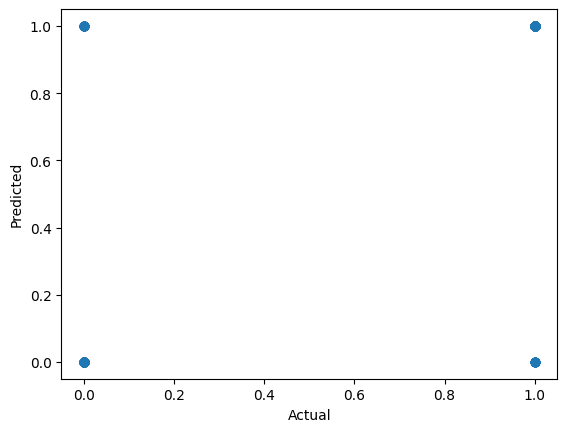

In [12]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

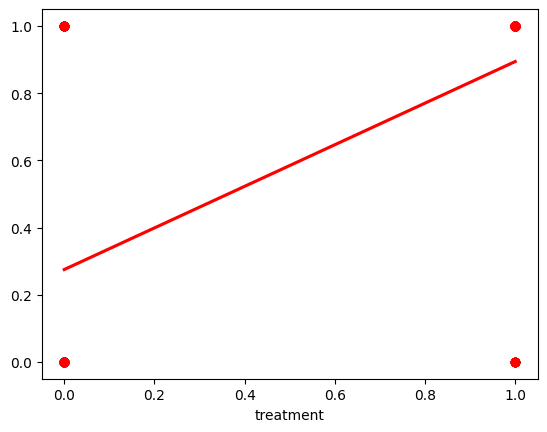

In [13]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');